In [1]:
import yfinance as yf
import pandas as pd 
import talib as ta
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
ticker='RELIANCE.NS'
startdate='2020-01-01'
enddate='2022-03-06'
df=yf.download(ticker,start=startdate,end=enddate)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1503.745972,1512.760498,1491.363403,1495.424927,1485.053467,6463060
2020-01-02,1497.802368,1526.480469,1497.802368,1520.883545,1510.335571,8173308
2020-01-03,1518.605103,1527.173950,1508.699097,1522.716187,1512.155518,9684434
2020-01-06,1505.727173,1513.552979,1483.933838,1487.400879,1477.085083,11315596
2020-01-07,1504.736572,1520.091064,1499.288208,1510.284058,1499.809570,7699489


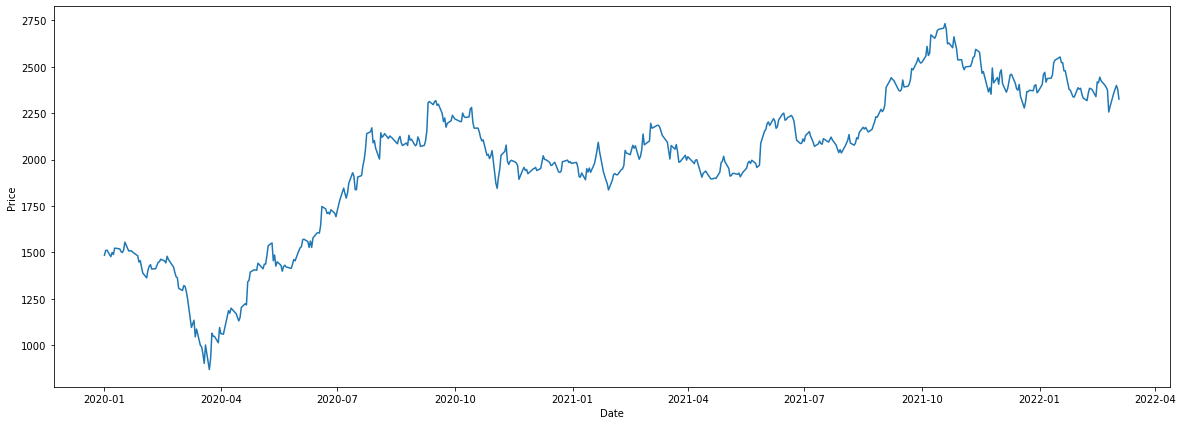

In [3]:
plt.figure(figsize=(20,7))
plt.plot(df['Adj Close'],label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
df['MACD'], df['MACDsignal'],_ = ta.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['RSI'] = ta.RSI(df['Adj Close'],timeperiod = 14)

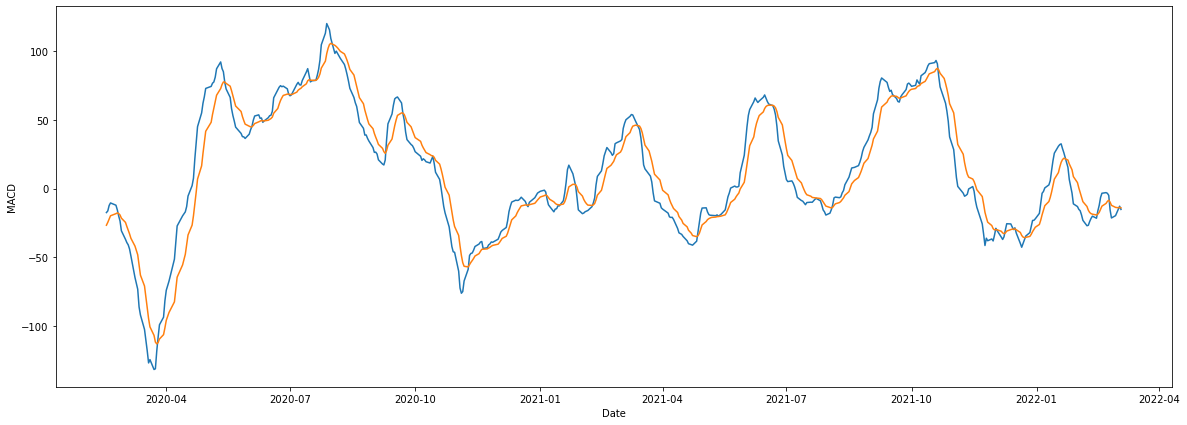

In [5]:
plt.figure(figsize=(20,7))
labels = ['MACD','MACDsignal']
plt.plot(df[['MACD','MACDsignal']], label=labels)
plt.xlabel('Date')
plt.ylabel('MACD')
plt.show()

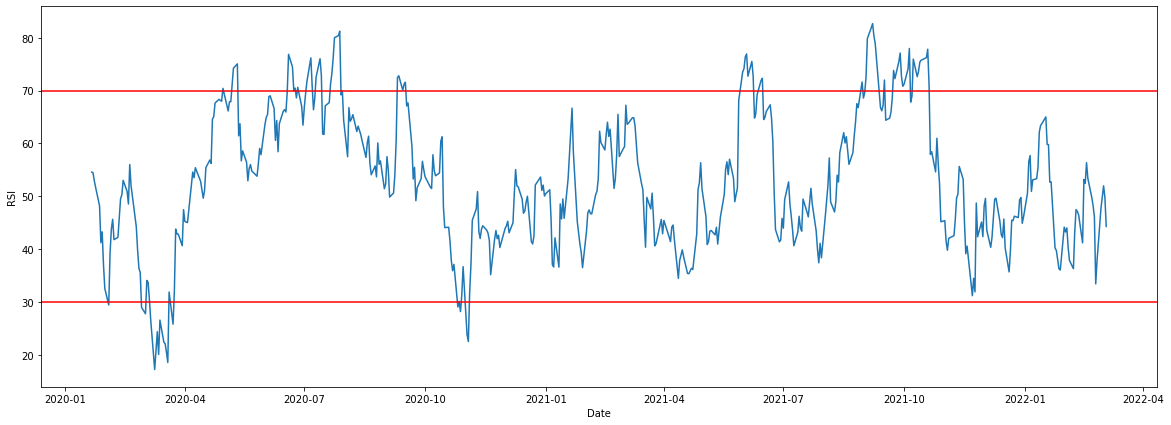

In [6]:
plt.figure(figsize=(20,7))
plt.plot(df['RSI'])
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y = 70 , color='red')
plt.axhline(y = 30, color='red')
plt.show()

In [7]:
def signal_generation(df,initial_money):
    Buy=[]
    Sell=[]
    position=False
    number_of_trades=0
    profitable_trades=0
    
    for r in range(0,34): #Because the data for macd and macd signal will have nans 
        Buy.append(np.nan)
        Sell.append(np.nan)
    
    for i in range(34, len(df)):
        if ((((df['MACD'][i-1]) < (df['MACDsignal'][i-1])) & ((df['MACD'][i]) > (df['MACDsignal'][i])))
            | (df['RSI'][i] < 30.0)):
            Sell.append(np.nan)
            if position ==False:
                Buy.append(df['Adj Close'][i])
                buy_price=df['Adj Close'][i]
                initial_money /= df['Adj Close'][i] 
                position=True
            else:
                Buy.append(np.nan)
        elif ((((df['MACD'][i-1]) > (df['MACDsignal'][i-1])) &((df['MACD'][i]) < (df['MACDsignal'][i])))
              | (df['RSI'][i] > 65.0)):
            Buy.append(np.nan)
            if position == True:
                number_of_trades=number_of_trades+1
                if df['Adj Close'][i]>buy_price:
                    profitable_trades=profitable_trades+1
                Sell.append(df['Adj Close'][i])
                initial_money *= df['Adj Close'][i]
                position=False
            else:
                Sell.append(np.nan)
        elif (position == True and df['Adj Close'][i] < buy_price * 0.9): #Stoploss
            Sell.append(df["Adj Close"][i])
            initial_money *= df['Adj Close'][i]
            Buy.append(np.nan)
            position = False
        elif (position == True and df['Adj Close'][i] > buy_price * 1.2): #Target
            Sell.append(df["Adj Close"][i])
            initial_money *= df['Adj Close'][i]
            Buy.append(np.nan)
            position = False
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)

    return (Buy,Sell,initial_money,number_of_trades,profitable_trades)

In [8]:
buy,sell,total,total_num_trades,profit_trades = signal_generation(df,20000)

In [9]:
len(buy)

542

In [10]:
len(df)

542

In [11]:
df['BUY'] = buy
df['SELL'] = sell

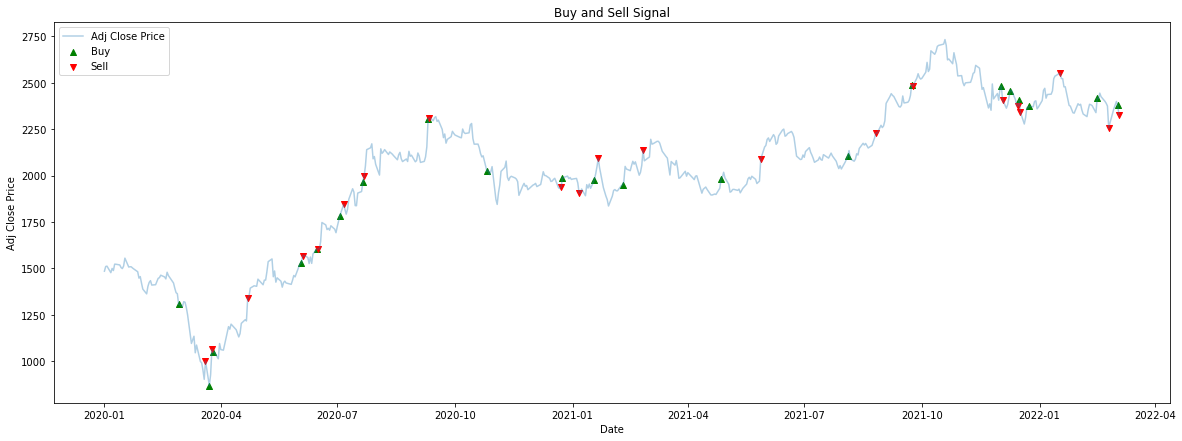

In [12]:
plt.figure(figsize=(20,7))
plt.scatter(df.index,df['BUY'],color='green',label='Buy',marker='^')
plt.scatter(df.index,df['SELL'],color='red',label='Sell',marker='v')
plt.plot(df['Adj Close'],label='Adj Close Price',alpha=0.35)
plt.title('Buy and Sell Signal')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend(loc='upper left')
plt.show()

In [13]:
print("Pecentage of profitable trades {:.0f}%".format((profit_trades/total_num_trades)*100))

Pecentage of profitable trades 56%


In [14]:
print("Profit:",total-20000)

Profit: 7646.143557102179
